<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 2 - Dantzig Selector </a></center>
<br/><br/>

In [54]:
import cvxpy as cp
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# 1- Problème de régression parcimonieuse et Dantzig Selector

On considère le modèle de régression normale
$$ y=X\theta+\sigma\xi,\;\;\xi\sim \mathcal{N}(0, I_m),$$
où  $X\in \mathbb{R}^{m\times n}$ et $y\in \mathbb{R}^m$ sont les observables, et $\theta\in \mathbb{R}^n$ est le paramètre inconnu. 


L'estimateur de $\theta$ de *``Dantzig Selector''* ([cf.](https://browse.arxiv.org/pdf/math/0506081.pdf) Candes, E., Tao, T. (2007). *The Dantzig selector: Statistical estimation when $p$ is much larger than $n$*. The Annals of Statistics, 2313-2351) peut être utilisé pour estimer $\theta$ dans le cas d'un modèle surparamétré, quand la dimension $n$ de $\theta$ est supérieure a la dimension de l'observation $y$.


Dans ce cas l'estimateur ${\theta}_{DS}$  s'écrit comme une solution du probleme d'optimisation
$$\min_{\theta\in  \mathbb{R}^n} \|\theta\|_1,~~~\;\mbox{sous contrainte}\;\|X^T(X\theta-y)\|_\infty\leq \kappa\sigma,$$
où $\kappa>0$ est un *hyper-paramètre*. 


La valeur de $\kappa$, préconisée dans la literature, est $c q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right)$, où $\alpha\in (0,1)$ est le niveau de risque choisi (par ex. $\alpha=.05$) et $q_\mathcal{N}(p)$ est la $p$-quantile de la normale standardisée, et $c=\max_j\|[X]_j\|_2=\max_j\sqrt{[X]_j^T[X]_j}$ est la norme maximale de colonne de la matrice $X$.

Votre objectif dans cet exercice sera d'implementer l'estimateur ${\theta}_{DS}$ en utilisant `CVXPY`.

> **Question:** Vérifier que le problème et les contraintes peuvent se formuler via des [fonctions disponibles](https://www.cvxpy.org/examples/index.html) pour CVXPY.

In [4]:
? cp.norm_inf

Init signature:  cp.norm_inf(expr, axis: Optional[int] = None, keepdims: bool = False) -> None
Docstring:      An abstract base class for atoms that can be applied along an axis.
File:           /usr/lib/python3.11/site-packages/cvxpy/atoms/norm_inf.py
Type:           type
Subclasses:     

In [6]:
? cp.norm1

Init signature:  cp.norm1(expr, axis: Optional[int] = None, keepdims: bool = False) -> None
Docstring:      An abstract base class for atoms that can be applied along an axis.
File:           /usr/lib/python3.11/site-packages/cvxpy/atoms/norm1.py
Type:           type
Subclasses:     

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        See for example <a style="color: black;" href="https://www.cvxpy.org/examples/machine_learning/lasso_regression.html"/> the lasso toy problem for $\|\|\cdot\|\|_1$</a>, or in general the doc of <a style="color: black;" href="https://www.cvxpy.org/api_reference/cvxpy.atoms.html">all the useful functions</a>.
    </p>
    <p>
        Note that the constraint and loss are both non-differentiable!
    </p>
</div>

# 2- Un petit exemple

In [31]:
# Exemple jouet
n = 5
m = 3
sigma = 0.1

X = np.random.randn(m,n)
theta_true = np.array([1,0,0,0,5])
xi = np.random.randn(m)
y = np.dot(X,theta_true) + sigma*xi



In [32]:
X

array([[-1.81193407, -0.07103095, -0.84191183,  0.62307177,  0.08580583],
       [ 0.63696157,  1.62622653,  0.35399621, -0.96346922, -0.30604226],
       [ 2.00613064, -0.20942947, -1.36350016, -0.30140501, -0.54590231]])

In [33]:
y

array([-1.38787947, -0.95048214, -0.70951557])

In [34]:
theta_true

array([1, 0, 0, 0, 5])

> **Question:** Trouver l'estimateur $\theta_{DS}$ à partir de $X$ et $y$ par résolution du problème d'optimisation via CVXPY avec $\kappa$ fixé à 0.2.

In [35]:
def solve_DS(X: np.array, y: np.array, kappa: float=.2, sigma=.1):
    assert X.shape[0] == y.shape[0]
    theta = cp.Variable(X.shape[1])

    L = cp.norm1(theta)
    obj = cp.Minimize(L)

    residuals = y - X @ theta
    constraints = [cp.norm_inf(X.T @ residuals) <= kappa * sigma]

    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")

    return prob.status, theta.value, prob.value, residuals.value

results = solve_DS(X, y, .2, sigma)
print(f"# {results[0]} #\nTheta: {results[1]}")

# optimal #
Theta: [ 2.87658626e-01 -9.24103618e-01  1.08185971e+00 -2.83205090e-13
  7.19173211e-13]


<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        We do have some sparsity, but notice that the first coefficient is bad...
    </p>
</div>

# 3- Fonction "Dantzig Selector"



> **Question:** Écrivez une fonction `DSelect` qui fait appel a `CVXPY` pour calculer l'estimation ${\theta}_{DS}$. 

Cette fonction doit sortir un tuple avec les elements
* `coef`, vecteur des coefficients de regression
* `resid`, vecteur $y-X{\theta}_{DS}$ de résidus
* `status`, le statut de sortie du solver

L'appel à cette fonction devra être:

`DSelect(X, y, sigma = 1, c = 1, verb = False)`

où
* `X` et `y` sont les observables
* `sigma` est une estimation de $\sigma$
* `c` est le paramètre réel tel que la valeur de $\kappa$ dans {DS} est $ \kappa=c\,q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right).$

In [36]:
import scipy.stats

def DSelect(X, y, sigma = 1, c = 1, verb = False):
    """
    Returns theta, the residuals (y - X theta)
    """
    m, n = X.shape
     
    alpha = 0.05
    kappa = c * scipy.stats.norm.ppf(1. - .5 * alpha / m)

    #### Done!
    sol_status, theta_ds, _, residual = solve_DS(X, y, kappa, sigma)
    ####
    
    return theta_ds, residual, sol_status

##  Test quand on connait le *vrai* theta

In [37]:
n = 5
m = 5
X = np.random.randn(m,n)
theta_true = np.random.randn(n)
sigma = 0.005

y = np.dot(X,theta_true) + sigma*np.random.randn(m)

Avec la valeur de sigma prise ci-dessus, vous devriez pouvoir appeler votre fonctions comme ci-dessous. 

In [38]:
f = DSelect(X, y, sigma=sigma)

> **Question:** Testez votre fonction sur cet exemple jouet. En particulier, comparez la valeur de `theta_ds` à la vraie valeur `theta_true`.

In [41]:
print(f"||theta-true_theta||={np.linalg.norm(f[0] - theta_true)}\n"
      f"Residual norm: {np.linalg.norm(f[1])}\n"
      f"Theta={f[0]}\n"
      f"True theta: {theta_true}")

||theta-true_theta||=0.3168957822182795
Residual norm: 0.09476455676201831
Theta=[ 2.25136881 -1.79487375  1.94658514 -0.35762823  1.18999507]
True theta: [ 2.41957223 -1.7366871   2.07532314 -0.57787675  1.1294808 ]


## Example du papier de Candes/Tao

In [43]:
n = 256
m = 72
S = 8

S_set = random.sample(range(n),k=S)

X = np.random.randn(m,n)

theta_true = np.zeros(n)
theta_true[S_set] = np.random.randn(S)

sigma = 1/3.0*np.sqrt(S/m)
y = np.dot(X,theta_true) + sigma*np.random.randn(m)

In [44]:
f = DSelect(X, y, sigma= sigma)

> **Question:** Testez votre fonction sur l'exemple du papier. Comparez la valeur de `theta_ds` à la vraie valeur `theta_true`. Essayer de changer `sigma`.

In [57]:
print(f"||theta-true_theta||={np.linalg.norm(f[0] - theta_true)}\n"
      f"Residual infty norm: {np.linalg.norm(f[1], float('inf'))}\n"
      f"Non-zero theta entries: {(np.abs(f[0]) > 1e-2).sum()}\n"
      f"For true theta: {(np.abs(theta_true) > 1e-2).sum()}")

||theta-true_theta||=0.06790886215341929
Residual infty norm: 0.09003714671352392
Non-zero theta entries: 18
For true theta: 8


### Support des solutions

La valeur cherchée `theta_true` est très parcimonieuse (elle contient beaucoup de zéros). Les seules valeurs non-null sont aux positions suivantes.

In [71]:
S_set

[224, 195, 98, 198, 141, 120, 207, 67]

In [72]:
theta_true

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.78291813,  0.        ,  0.  

> **Question:** Comparez le nombre et l'emplacement des zéros dans `theta_ds` à ceux dans `theta_true`. Essayez de changer `c`.

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        By changing $\sigma$, we restrict the box constraint, so the solver needs to provide more nonzero values to explore the minimum.
    </p>
</div>

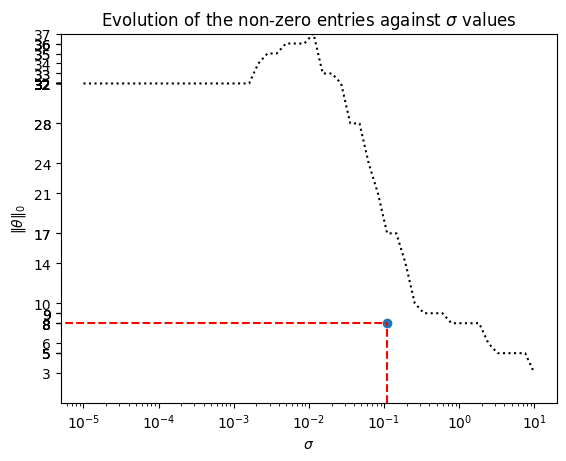

In [78]:
def solve_for_sigma(X, y):
    sigmas = np.logspace(-5, 1, base=10)
    non_z = [(np.abs(DSelect(X, y, sigma=sigma)[0]) > 1e-2).sum() for sigma in sigmas]
    plt.plot(sigmas, non_z, 'k:')
    plt.xscale('log')
    plt.xlabel(r"$\sigma$")
    plt.ylabel(r"$\|\theta\|_0$")
    plt.yticks(non_z)
    plt.title(r"Evolution of the non-zero entries against $\sigma$ values")

    # Plot the supposed number of zeroes for the sigma in the paper
    sigma_opt = np.sqrt(S / m) / 3.0
    plt.scatter([sigma_opt], [8])
    plt.plot([sigma_opt, sigma_opt], [0, 8], 'r--')
    plt.plot([0, sigma_opt], [8, 8], 'r--')

    plt.ylim([0, np.max(non_z)])
    plt.show()
solve_for_sigma(X, y)

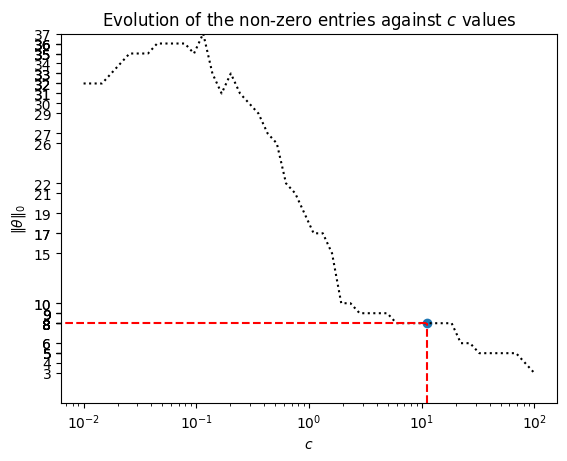

In [77]:
def solve_for_c(X, y):
    cs = np.logspace(-2, 2, base=10)
    sigma_opt = np.sqrt(S / m) / 3.0
    non_z = [(np.abs(DSelect(X, y, sigma=sigma_opt, c=c)[0]) > 1e-2).sum() for c in cs]
    plt.plot(cs, non_z, 'k:')
    plt.xscale('log')
    plt.xlabel(r"$c$")
    plt.ylabel(r"$\|\theta\|_0$")
    plt.yticks(non_z)
    plt.title("Evolution of the non-zero entries against $c$ values")

    # Plot the supposed number of zeroes for the c in the paper
    c_opt = np.max(np.linalg.norm(X, axis=0))
    plt.scatter([c_opt], [8])
    plt.plot([c_opt, c_opt], [0, 8], 'r--')
    plt.plot([0, c_opt], [8, 8], 'r--')

    plt.ylim([0, np.max(non_z)])
    plt.show()
solve_for_c(X, y)

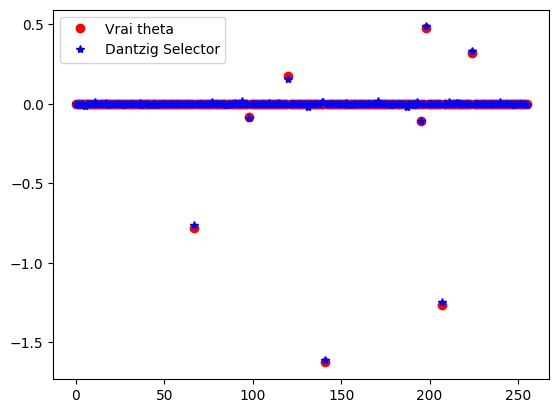

In [73]:
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();